In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client

client = Client(processes=True)
client

Client Scheduler: tcp://127.0.0.1:52841 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [3]:
epoch_key = 'bon', 3, 2
exclude_interneuron_spikes = False

In [4]:
from src.load_data import load_data
import logging

logging.basicConfig(level='INFO', format='%(asctime)s %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S')

animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

logging.info('Loading data...')
data = load_data(epoch_key,
                 exclude_interneuron_spikes=exclude_interneuron_spikes)

29-Dec-20 14:01:03 Loading data...
29-Dec-20 14:01:04 Loading position info...
29-Dec-20 14:05:55 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
29-Dec-20 14:05:55 No DIO file found, using distance from well to segment trials
29-Dec-20 14:05:55 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
29-Dec-20 14:05:55 No DIO file found, inferring correct inbound/outbound from task rules
29-Dec-20 14:06:34 Loading spikes...
29-Dec-20 14:06:58 Loading multiunit...
29-Dec-20 14:07:02 Finding ripple times...
29-Dec-20 14:21:04 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
29-Dec-20 14:21:04 No DIO file found, using distance from well to segment trials
29-Dec-20 14:21:05 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
29-Dec-20 14:21:05 No DIO file found, 

In [5]:
client.close()

In [6]:
from loren_frank_data_processing.position import (EDGE_ORDER, EDGE_SPACING,
                                                  make_track_graph)
from src.parameters import ANIMALS, PROCESSED_DATA_DIR

is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

In [98]:
import os
import xarray as xr
from replay_trajectory_classification import ClusterlessClassifier
from loren_frank_data_processing import reshape_to_segments


model_name = os.path.join(
    PROCESSED_DATA_DIR,
    f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl')

results = xr.open_dataset(
    os.path.join(
        PROCESSED_DATA_DIR, f'{animal}_{day:02}_{epoch:02}.nc'),
    group=f'/{data_type}/{dim}/classifier/ripples/')
logging.info('Found existing results. Loading...')
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)
classifier = ClusterlessClassifier.load_model(model_name)

29-Dec-20 21:34:35 Found existing results. Loading...


In [237]:
import numpy as np


def tetrode_identity_shuffle(multiunit):
    """Shuffle the correspondence between tetrodes and spike time
    """
    n_tetrodes = len(multiunit.tetrodes)
    rand_tetrode_index = np.random.randint(
        low=0, high=n_tetrodes, size=n_tetrodes)
    return multiunit.isel(tetrodes=rand_tetrode_index)


# Fit as normal, then shuffle when predicting

In [254]:
import xarray as xr


def spike_time_shuffle(multiunit):
    """Shuffle each tetrode spike time by a random amount
    """
    n_time = len(multiunit.time)
    n_tetrodes = len(multiunit.tetrodes)
    
    rand_time_offset = np.random.randint(
        low=-(n_time-1)//2, high=(n_time-1)//2, size=n_tetrodes)
    shuffled_multiunit = [
        multiunit.isel(tetrodes=tetrode_ind, drop=False).roll(
            time=time_offset_ind, roll_coords=False)
        for tetrode_ind, time_offset_ind in enumerate(rand_time_offset)]
    
    return xr.concat(
        shuffled_multiunit, dim=multiunit.tetrodes
    ).transpose(*multiunit.dims)

In [248]:
import pandas as pd


def shuffle_run_position(position_info):
    n_time = position_info.shape[0]
    shuffled_position = pd.Series(np.full((n_time,), np.nan),
                                  index=position_info.index)
    
    for segment, df in position_info.groupby('labeled_segments'):
        n_segment_time = df.shape[0]
        if (segment == 0) | (n_segment_time == 1):
            shift = 0
        elif n_segment_time == 2:
            shift = np.random.randint(low=0, high=2)
        else:
            midpoint = (n_segment_time - 1)//2
            shift = np.random.randint(low=-1 * midpoint,
                                      high=midpoint)
            
        shuffled_position.loc[df.index] = np.roll(
            df.linear_position, shift=shift)
            
    return shuffled_position

In [117]:
from replay_trajectory_classification.multiunit_likelihood import (
    fit_multiunit_likelihood, atleast_2d)

def get_tetrode_place_field(position, multiunits):
    position = atleast_2d(np.asarray(position))
    multiunits = np.asarray(multiunits)

    (_, ground_process_intensities,
     occupancy, _) = fit_multiunit_likelihood(
                    position,
                    multiunits,
                    classifier.place_bin_centers_,
                    classifier.model,
                    classifier.model_kwargs,
                    classifier.occupancy_model,
                    classifier.occupancy_kwargs,
                    classifier.is_track_interior_.ravel(order='F'))
    
    return np.stack(ground_process_intensities, axis=0).squeeze()

In [118]:
place_fields = get_tetrode_place_field(data['position_info'].linear_position, data['multiunit'])

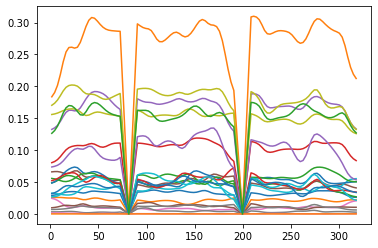

In [259]:
import matplotlib.pyplot as plt

for field in place_fields:
    plt.plot(classifier.place_bin_centers_, field)

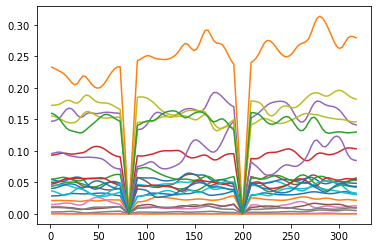

In [256]:
place_fields = get_tetrode_place_field(data['position_info'].linear_position,
                                       spike_time_shuffle(data['multiunit']))
for field in place_fields:
    plt.plot(classifier.place_bin_centers_, field)

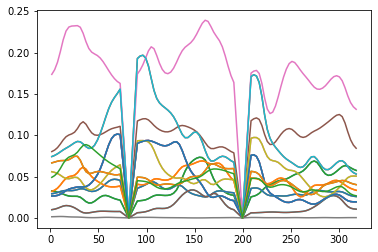

In [257]:
place_fields = get_tetrode_place_field(data['position_info'].linear_position,
                                       tetrode_identity_shuffle(data['multiunit']))
for field in place_fields:
    plt.plot(classifier.place_bin_centers_, field)

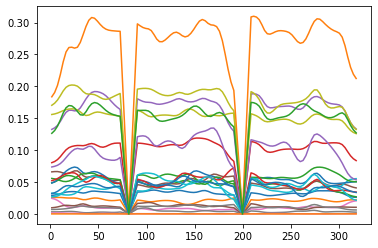

In [258]:
place_fields = get_tetrode_place_field(shuffle_run_position(data['position_info']),
                                       data['multiunit'])
for field in place_fields:
    plt.plot(classifier.place_bin_centers_, field)

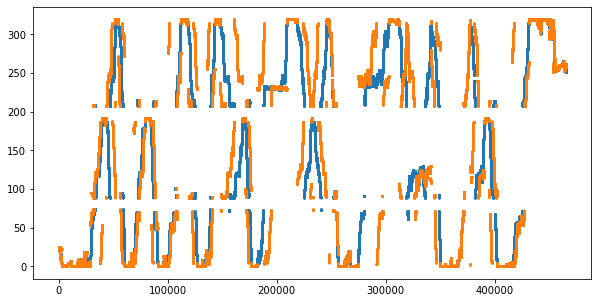

In [260]:
plt.figure(figsize=(10, 5))
n_time = data['position_info'].linear_position.shape[0]
plt.scatter(np.arange(n_time), data['position_info'].linear_position.values, s=1)
plt.scatter(np.arange(n_time), shuffle_run_position(data['position_info']), s=1)

In [313]:
likelihood = results.sel(ripple_number=1, state='Hover').acausal_posterior.dropna('time', how='all')
likelihood

<xarray.DataArray 'acausal_posterior' (time: 54, position: 101)>
array([[9.807693e-01, 3.014251e-03, 2.122340e-04, ..., 2.139286e-08,
        7.474641e-08, 1.980981e-07],
       [9.805751e-01, 3.037459e-03, 2.162584e-04, ..., 1.185320e-08,
        4.205445e-08, 1.131805e-07],
       [9.804021e-01, 3.060976e-03, 2.204133e-04, ..., 4.606473e-09,
        1.641374e-08, 4.467445e-08],
       ...,
       [9.759133e-01, 3.610549e-03, 3.183169e-04, ..., 2.658203e-09,
        2.490924e-09, 2.380874e-09],
       [9.762022e-01, 3.615159e-03, 3.157356e-04, ..., 2.511032e-09,
        2.481925e-09, 2.475588e-09],
       [9.764915e-01, 3.619328e-03, 3.132817e-04, ..., 2.189038e-09,
        2.249925e-09, 2.312581e-09]])
Coordinates:
    state          <U5 'Hover'
  * time           (time) timedelta64[ns] 00:00:00 ... 00:00:00.106000
  * position       (position) float64 1.481 4.442 7.404 ... 312.2 315.1 318.0
    ripple_number  int64 1

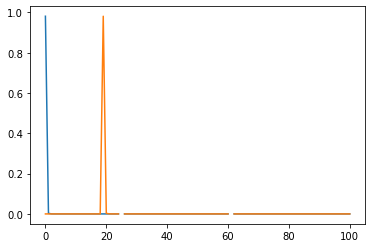

In [314]:

def shuffle_likelihood_position(likelihood, classifier):
    '''Circularly shuffle each likelihood position for each time
    '''
    likelihood = np.asarray(likelihood)
    shuffled_likelihood = np.full_like(likelihood, np.nan)
    n_time = likelihood.shape[0]
    n_position_bins = int(classifier.is_track_interior_.sum())
    midpoint = (n_position_bins - 1) // 2

    for time_ind in range(n_time):
        shift = np.random.randint(
            low=-midpoint, high=midpoint, size=1)
        shuffled_likelihood[time_ind, classifier.is_track_interior_] = np.roll(
            likelihood[time_ind, classifier.is_track_interior_], shift)
    
    return shuffled_likelihood

shuffled_likelihood = shuffle_likelihood_position(likelihood, classifier)
plt.plot(likelihood[0])
plt.plot(shuffled_likelihood[0])

In [ ]:
import pandas as pd


def shuffle_run_position2(position_info):
    n_time = position_info.shape[0]
    shuffled_position = pd.Series(np.full((n_time,), np.nan),
                                  index=position_info.index)
    
    for segment, df in position_info.groupby('labeled_segments'):
        n_segment_time = df.shape[0]
        if (segment == 0) | (n_segment_time == 1):
            shift = 0
        elif n_segment_time == 2:
            shift = np.random.randint(low=0, high=2)
        else:
            midpoint = (n_segment_time - 1)//2
            shift = np.random.randint(low=-1 * midpoint,
                                      high=midpoint)
            
        shuffled_position.loc[df.index] = np.roll(
            df.linear_position, shift=shift)
            
    return shuffled_position

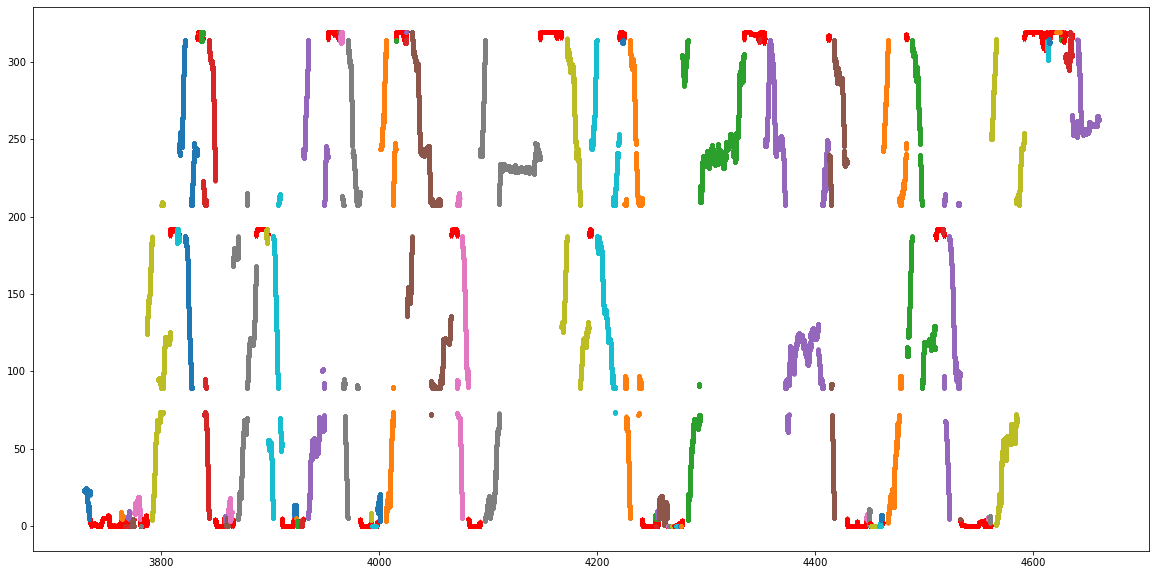

In [340]:
position_info = data['position_info']

plt.figure(figsize=(20, 10))
for segment, df in position_info.groupby('labeled_segments'):
    if df.speed.mean() > 4:
        plt.scatter(df.index / np.timedelta64(1,'s'), np.roll(df.linear_position, 2500), s=10)
    else:
        plt.scatter(df.index / np.timedelta64(1,'s'), df.linear_position, color='red', s=10, marker='*')

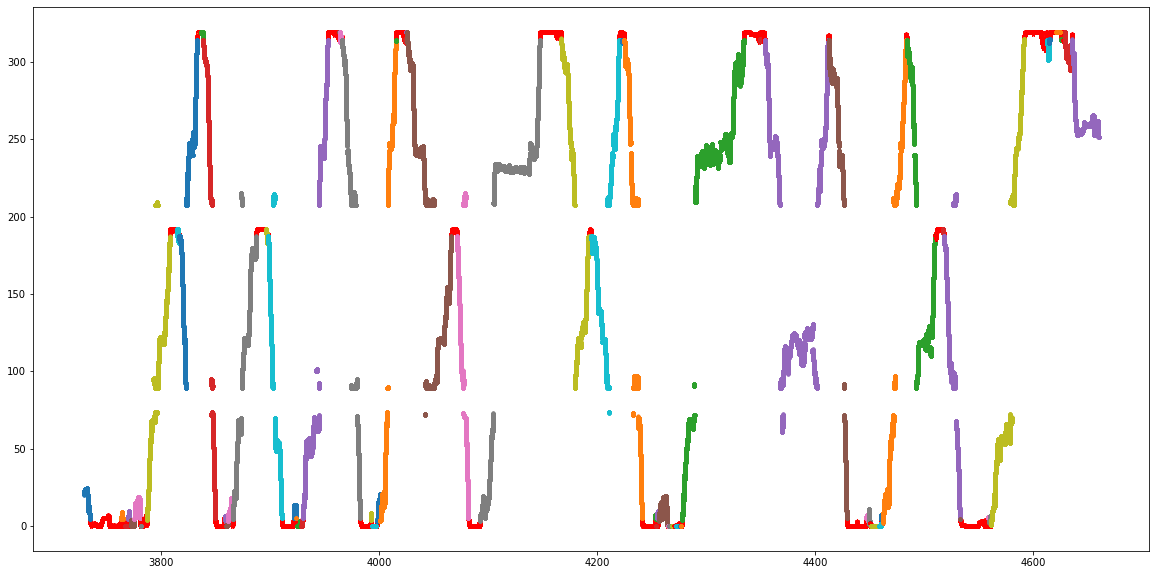

In [341]:
position_info = data['position_info']

plt.figure(figsize=(20, 10))
for segment, df in position_info.groupby('labeled_segments'):
    if df.speed.mean() > 4:
        plt.scatter(df.index / np.timedelta64(1,'s'), df.linear_position, s=10)
    else:
        plt.scatter(df.index / np.timedelta64(1,'s'), df.linear_position, color='red', s=10, marker='*')

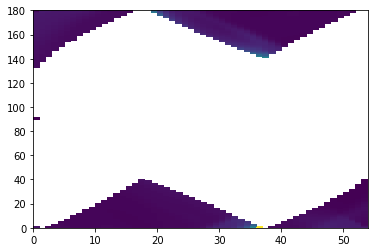

In [366]:
from skimage.transform import radon

plt.pcolormesh(radon(image=likelihood.dropna.values, theta=None, circle=True).T)

In [385]:
R = radon(np.eye(10), theta=np.arange(0, 180, 0.5))
np.max(R), np.argmax(R)

(6.708586077601689, 1890)

In [361]:
likelihood.values.shape

(54, 101)

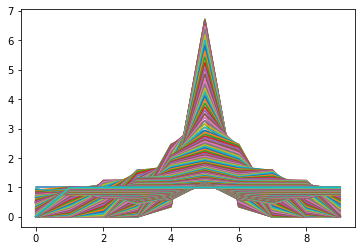

In [391]:
for r in R.T:
    plt.plot(r)